[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LorenzoRimella/epidemiology_workshop/blob/main/UP_Diliman/PAL.ipynb)

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep
import time
import scipy.stats as stats
from scipy import stats
import scipy

import numpy as np

gaussian = stats.norm

In [3]:
def SIR_step_0(N, p_0, n_simulation = 1): # shape is the

    X_0 = tfp.distributions.Multinomial(total_count = N, probs = p_0)

    return X_0.sample((n_simulation))

In [4]:
def K_SIR(beta, gamma, x):

    N = tf.reduce_sum(x, axis = -1)

    prob_SI = 1 - tf.math.exp(-tf.einsum("p,sp->sp", beta, x[...,1]/N))
    prob_IR = 1 - tf.math.exp(-tf.einsum("p,sp->sp", gamma, tf.ones(tf.shape(x[...,1]))))

    prob_SI = tf.expand_dims(prob_SI, axis = -1)
    prob_IR = tf.expand_dims(prob_IR, axis = -1)

    K_x_row_1 = tf.concat((             1 -  prob_SI  ,                   prob_SI  , tf.zeros(tf.shape(prob_SI)) ), axis = -1)
    K_x_row_2 = tf.concat((tf.zeros(tf.shape(prob_SI)),               1 - prob_IR  ,                   prob_IR   ), axis = -1)
    K_x_row_3 = tf.concat((tf.zeros(tf.shape(prob_SI)), tf.zeros(tf.shape(prob_SI)),  tf.ones(tf.shape(prob_SI)) ), axis = -1)

    return tf.stack((K_x_row_1, K_x_row_2, K_x_row_3), axis = -2)

In [5]:
def SIR_step_t(beta, gamma, x_tm1):

    K_tm1 = K_SIR(beta, gamma, x_tm1)

    multinomial_kernel = tfp.distributions.Multinomial(x_tm1, probs = K_tm1)

    Z_tm1_t = multinomial_kernel.sample()

    return tf.reduce_sum(Z_tm1_t, axis = -2)

We can enclose everything in a function...

In [6]:
def SIR_observe_t(q, x_t):

    q_expanded = tf.einsum("spi,pi->spi", tf.ones(tf.shape(x_t)), q  )

    emission_distribution = tfp.distributions.Binomial(x_t, probs = q_expanded)

    return emission_distribution.sample()

In [7]:
@tf.function(jit_compile=True)
def compartmental_model_simulation(p_0, beta, gamma,
                                   q,
                                   T = 100, n_simulations = 1):

    x_0 = SIR_step_0(N, p_0, n_simulations)
    y_0 = -10*tf.ones(tf.shape(x_0))

    def body(input, t):

        x_tm1, _ = input

        x_t = SIR_step_t(beta, gamma, x_tm1)
        y_t = SIR_observe_t(q, x_t)

        return x_t, y_t

    X, Y = tf.scan(body, tf.range(0, T), initializer = (x_0, y_0))

    return tf.concat((tf.expand_dims(x_0, axis = 0), X), axis = 0), Y

# Simulate the data

In [8]:
N = 10000 # population of 1000 individuals
p_0 = tf.convert_to_tensor([[0.99, 0.01, 0.0]], dtype = tf.float32) # we have a parameter dimension

beta  = tf.convert_to_tensor([0.2], dtype = tf.float32) # again a parameters dimension
gamma = tf.convert_to_tensor([0.1], dtype = tf.float32) # again a parameters dimension

q = tf.convert_to_tensor([[0.0, 0.1, 0.0]], dtype = tf.float32) # we have again a parameter dimension

T = 200

X, Y =  compartmental_model_simulation(p_0, beta, gamma, q, T, 1)


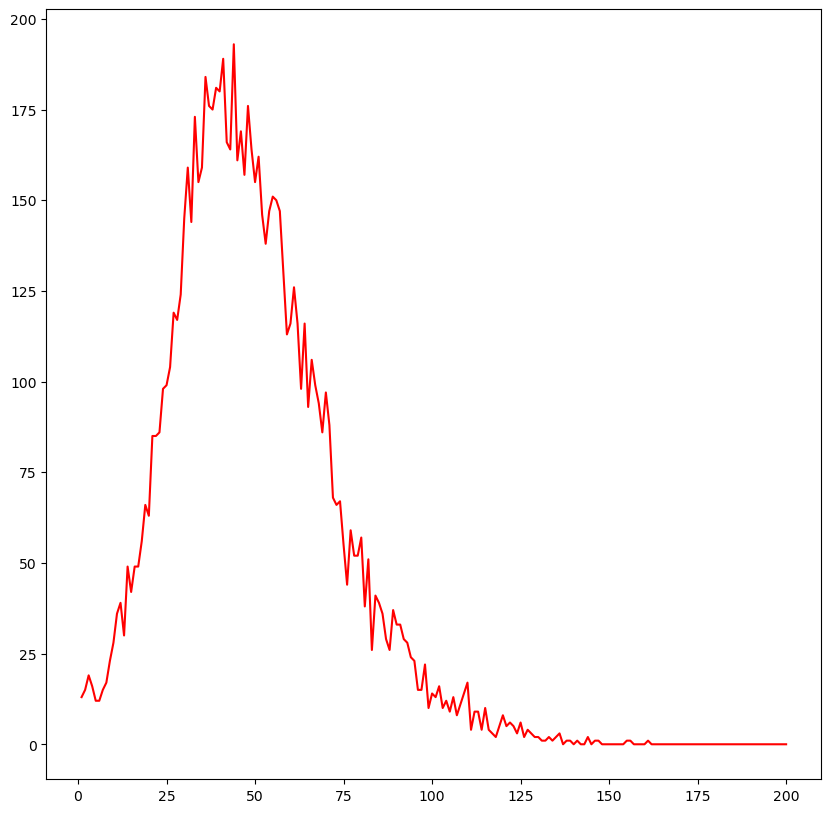

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

time_steps = np.linspace(0, 200, 201)

ax.plot(time_steps[1:], Y[:,0,0,1], color = "red")

# Poisson approximate likelihood

Under this dynamic :
$$
X_0 \sim Multinomial(N, p_0) \text{ and }
$$
$$
X_t^{(j)} = \sum_{i = 1}^M  Z_{t-1, t}^{(i,j)} \text{ for } j = 1,\dots,M \text{ and with } Z_{t-1, t}^{(i,\cdot)} \sim Multinomial(X_{t-1}^{(i)}, K_{X_{t-1}}^{(i,\cdot)}) \text{ for } i = 1,\dots,M
$$
and this emission:
$$
Y_t^{(i)} \sim Binomial(X_t^{(i)}, q^{(i)}),
$$
we can build a nice Poisson approximation.

Precisely, if $X_{t-1}|y_{1:t-1} \sim Poisson(\lambda_{t-1})$ then under the dinamic:
$$
X_t^{(j)} = \sum_{i = 1}^M  Z_{t-1, t}^{(i,j)} \text{ for } j = 1,\dots,M \text{ and with } Z_{t-1, t}^{(i,\cdot)} \sim Multinomial(X_{t-1}^{(i)}, K_{\lambda_{t-1}}^{(i,\cdot)}) \text{ for } i = 1,\dots,M
$$
we have:
$$
X_{t}|y_{1:t-1} \sim Poisson( (\lambda_{t-1}^\top K_{\lambda_{t-1}})^\top)
$$

This tell us that if we start with $X_0 \sim Multinomial(N, p_0) \approx Poisson(N p_0)$ then the first prediction step is easy... But we want our kernel to work on $\lambda_{t-1}$ and not $X_{t-1}$.

In [10]:
def K_SIR_poisson(N, beta, gamma, lambda_tm1):

    prob_SI = 1 - tf.math.exp(-tf.einsum("p,p->p", beta, lambda_tm1[...,1]/N))
    prob_IR = 1 - tf.math.exp(-tf.einsum("p,p->p", gamma, tf.ones(tf.shape(lambda_tm1[...,1]))))

    prob_SI = tf.expand_dims(prob_SI, axis = -1)
    prob_IR = tf.expand_dims(prob_IR, axis = -1)

    K_x_row_1 = tf.concat((             1 -  prob_SI  ,                   prob_SI  , tf.zeros(tf.shape(prob_SI)) ), axis = -1)
    K_x_row_2 = tf.concat((tf.zeros(tf.shape(prob_SI)),               1 - prob_IR  ,                   prob_IR   ), axis = -1)
    K_x_row_3 = tf.concat((tf.zeros(tf.shape(prob_SI)), tf.zeros(tf.shape(prob_SI)),  tf.ones(tf.shape(prob_SI)) ), axis = -1)

    return tf.stack((K_x_row_1, K_x_row_2, K_x_row_3), axis = -2)


Our prediction will then be

In [11]:
N = 10000 # population of 1000 individuals
p_0 = tf.convert_to_tensor([[0.99, 0.01, 0.0]], dtype = tf.float32) # we have a parameter dimension

lambda_tm1 = N*p_0

beta  = tf.convert_to_tensor([0.2], dtype = tf.float32) # again a parameters dimension
gamma = tf.convert_to_tensor([0.1], dtype = tf.float32) # again a parameters dimension

K_lambda_tm1 = K_SIR_poisson(N, beta, gamma, lambda_tm1)

lambda_t_tm1 = tf.einsum("pi,pij->pj", lambda_tm1, K_lambda_tm1)
print(lambda_t_tm1)

tf.Tensor([[9.8802197e+03 1.1026401e+02 9.5162630e+00]], shape=(1, 3), dtype=float32)


Create an approximate prediction

In [12]:
def poisson_prediction(lambda_tm1, K_lambda_tm1):

    return tf.einsum("pi,pij->pj", lambda_tm1, K_lambda_tm1)

Now given $X_t|y_{1:t-1} \sim Poisson(\lambda_{t|t-1})$ and given the emission:
$$
Y_t^{(i)} \sim Binomial(X_t^{(i)}, q^{(i)}),
$$
we get an approximate Multinomial for the next filter:
$$
X_t|y_{1:t} \approx Poisson\left (y_t + (\mathbf{1}_m-q) \circ \lambda_{t|t-1} \right)
$$
and an exact likelihood:
$$
Y_t \sim Poisson \left ( \lambda_{t|t-1} \circ q  \right ).
$$

We can then build our update

In [13]:
y_1t = Y[:,0,...]

y_t = y_1t[0,...]

q = tf.convert_to_tensor([[0.0, 0.1, 0.0]], dtype = tf.float32) # we have again a parameter dimension

lambda_t = y_t + (1 - q)*lambda_t_tm1

poisson_parameters = q*lambda_t_tm1 + 1e-10

poisson_likelihood = tfp.distributions.Poisson( rate = poisson_parameters)
poisson_likelihood_value = poisson_likelihood.log_prob(y_t)

log_likelihood_increment = tf.reduce_sum(poisson_likelihood_value, axis = -1)

and so the update function

In [14]:
def poisson_update(lambda_t_tm1, q, y_t):

    lambda_t = y_t + (1 - q)*lambda_t_tm1

    poisson_parameters = q*lambda_t_tm1 + 1e-10

    poisson_likelihood = tfp.distributions.Poisson( rate = poisson_parameters)

    log_likelihood_increment = tf.reduce_sum(tf.math.log(poisson_likelihood.prob(y_t)), axis = -1)

    return lambda_t, log_likelihood_increment

We can then combine them recursively and create the MAL

In [15]:
@tf.function(jit_compile=True)
def compartmental_model_PAL(N, p_0, beta, gamma, q, y_1t):

    T = tf.shape(y_1t)[0]

    lambda_0 = N*p_0
    initial_likelihood = tf.zeros(tf.shape(lambda_0)[:-1])

    def body(input, t):

        lambda_tm1, _ = input

        K_lambda_tm1 = K_SIR_poisson(N, beta, gamma, lambda_tm1)
        lambda_t_tm1 = poisson_prediction(lambda_tm1, K_lambda_tm1)

        y_t = y_1t[t,...]
        lambda_t, log_likelihood_increment = poisson_update(lambda_t_tm1, q, y_t)

        return lambda_t, log_likelihood_increment

    Lambda, LogLike = tf.scan(body, tf.range(0, T), initializer = (lambda_0, initial_likelihood))

    return tf.concat((tf.expand_dims(lambda_0, axis = 0), Lambda), axis = 0), LogLike

In [16]:
p_0 = tf.convert_to_tensor([[0.99, 0.01, 0.0]], dtype = tf.float32) # we have a parameter dimension

beta  = tf.convert_to_tensor([0.2], dtype = tf.float32) # again a parameters dimension
gamma = tf.convert_to_tensor([0.1], dtype = tf.float32) # again a parameters dimension

y_1t = Y[:,0,...]

q = tf.convert_to_tensor([[0.0, 0.1, 0.0]], dtype = tf.float32) # we have again a parameter dimension

Lambda, LogLike = compartmental_model_PAL(N, p_0, beta, gamma, q, y_1t)

print("The Multinomial approximate likelihood is ", tf.reduce_sum(LogLike).numpy())

The Multinomial approximate likelihood is  -451.74393


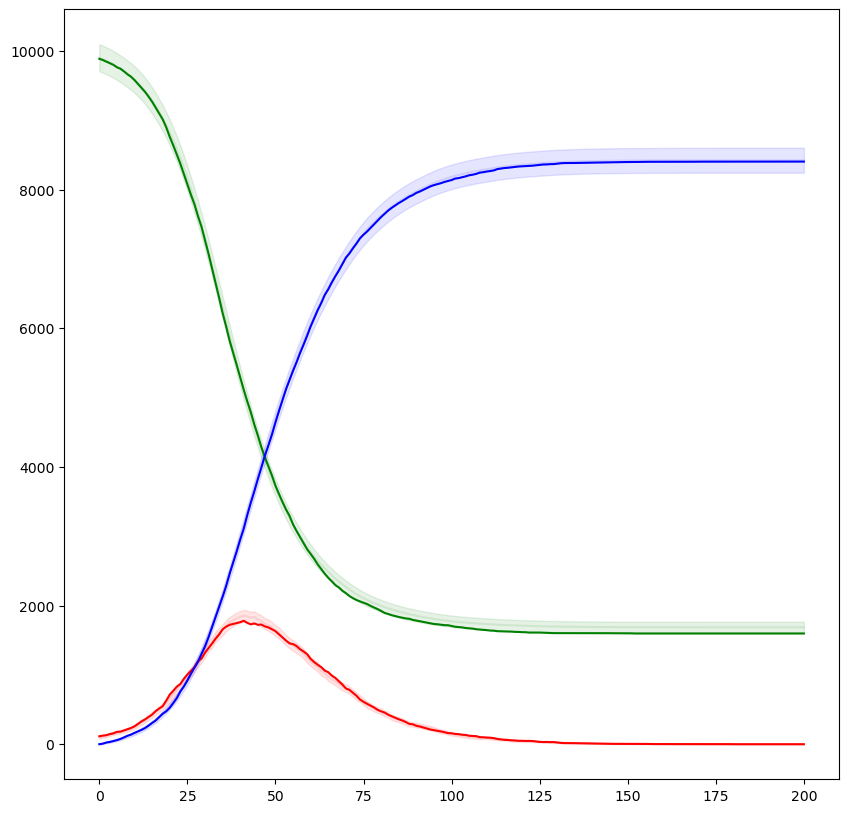

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

time_grid = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])
ax.plot(time_grid, X[:,0,0,0], color = "green")
ax.plot(time_grid, X[:,0,0,1], color = "red")
ax.plot(time_grid, X[:,0,0,2], color = "blue")

ax.plot(time_grid, Lambda[:,0,0], color = "green", alpha = 0.1)
std_S = tf.math.sqrt(Lambda[:,0,0])
ax.fill_between(time_grid, Lambda[:,0,0] - 1.96*std_S, Lambda[:,0,0] + 1.96*std_S, color = "green", alpha = 0.1)

ax.plot(time_grid, Lambda[:,0,1], color = "red", alpha = 0.1)
std_I = tf.math.sqrt(Lambda[:,0,1])
ax.fill_between(time_grid, Lambda[:,0,1] - 1.96*std_I, Lambda[:,0,1] + 1.96*std_I, color = "red", alpha = 0.1)

ax.plot(time_grid, Lambda[:,0,2], color = "blue", alpha = 0.1)
std_R = tf.math.sqrt(Lambda[:,0,2])
ax.fill_between(time_grid, Lambda[:,0,2] - 1.96*std_R, Lambda[:,0,2] + 1.96*std_R, color = "blue", alpha = 0.1)

We can even go one step further and run our algorithm in parallel on multiple $\beta$'s to find the maximum on the grid.

In [18]:
multi_size = 1000

p_0_multi = tf.convert_to_tensor([[0.99, 0.01, 0.0]], dtype = tf.float32)*tf.ones((multi_size, 1))

beta_multi  = tf.convert_to_tensor(np.linspace(0.01, 1, multi_size), dtype = tf.float32)
gamma_multi = tf.convert_to_tensor(0.1, dtype = tf.float32)*tf.ones((multi_size))

q_multi = tf.convert_to_tensor([[0.0, 0.1, 0.0]], dtype = tf.float32)*tf.ones((multi_size, 1))

Lambda_multi, LogLike_multi = compartmental_model_PAL(N, p_0_multi, beta_multi, gamma_multi, q_multi, y_1t)


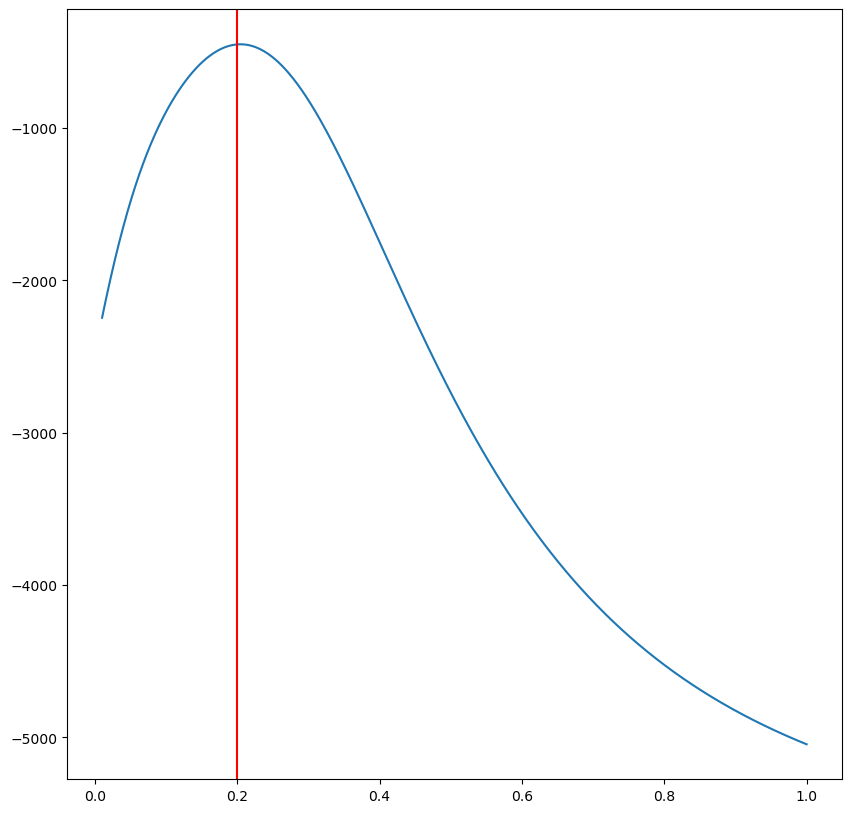

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ax.plot(beta_multi, tf.reduce_sum(LogLike_multi, axis =0))
ax.axvline(x = beta.numpy(), color = "red")

### Gradient ascent

The gradient computation is free if we use autodiff, we just need to define $\beta$ as a variable and tensorflow will track the gradient for us.

However we need cannot jit_compile and we need to make the $\beta$ dependence explicit

In [20]:
@tf.function
def compartmental_model_PAL(N, p_0, beta, gamma, q, y_1t):

    T = tf.shape(y_1t)[0]

    lambda_0 = N*p_0
    initial_likelihood = tf.zeros(tf.shape(lambda_0)[:-1])

    def body(input, t):

        lambda_tm1, _ = input

        K_lambda_tm1 = K_SIR_poisson(N, beta, gamma, lambda_tm1)
        lambda_t_tm1 = poisson_prediction(lambda_tm1, K_lambda_tm1)

        y_t = y_1t[t,...]
        lambda_t, log_likelihood_increment = poisson_update(lambda_t_tm1, q, y_t)

        return lambda_t, log_likelihood_increment

    Lambda, LogLike = tf.scan(body, tf.range(0, T), initializer = (lambda_0, initial_likelihood))

    return tf.concat((tf.expand_dims(lambda_0, axis = 0), Lambda), axis = 0), LogLike

Sample a $\beta$ at random until you get sensible likelihoods

In [21]:
beta_to_optim = tf.convert_to_tensor(np.random.uniform(0.01, 0.99, 1), dtype = tf.float32)
beta_opti = tf.Variable(beta_to_optim)

multi_size = 1

p_0_opti = tf.convert_to_tensor([[0.99, 0.01, 0.0]], dtype = tf.float32)*tf.ones((multi_size, 1))

gamma_opti = tf.convert_to_tensor(0.1, dtype = tf.float32)*tf.ones((multi_size))

q_opti = tf.convert_to_tensor([[0.0, 0.1, 0.0]], dtype = tf.float32)*tf.ones((multi_size, 1))

def loss_function(beta_to_optimise):

    _, LogLike_optim = compartmental_model_PAL(N, p_0_opti, beta_to_optimise, gamma_opti, q_opti, y_1t)

    return -tf.reduce_sum(LogLike_optim, axis = 0)

This is the sampled $\beta$

In [22]:
beta_to_optim

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8444421], dtype=float32)>

Calling our loss function will output the negative log likelihood

In [23]:
loss_function(beta_opti)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([inf], dtype=float32)>

Now we can choose our favourite optimiser

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

Compute the gradient

In [25]:
with tf.GradientTape() as tape:
    # Call your likelihood function with the parameters_var and other necessary inputs
    loss = loss_function(beta_opti)

# Use TensorFlow's automatic differentiation to compute gradients
gradients = tape.gradient(loss, [beta_opti])

Apply the optimizer

In [26]:
optimizer.apply_gradients(zip(gradients, [beta_opti]))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

Check the parameter

In [27]:
beta_opti

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([nan], dtype=float32)>

We can do this recursively and optimize our beta

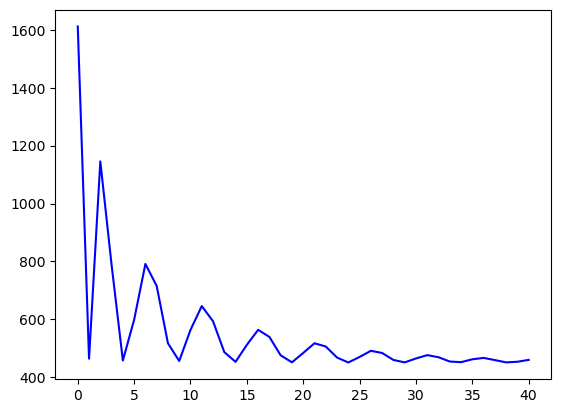

In [28]:
beta_to_optim = tf.convert_to_tensor(np.random.uniform(0.01, 0.99, 1), dtype = tf.float32)
beta_opti = tf.Variable(beta_to_optim)

while loss_function(beta_opti)>1e10:
    beta_to_optim = tf.convert_to_tensor(np.random.uniform(0.01, 0.99, 1), dtype = tf.float32)
    beta_opti = tf.Variable(beta_to_optim)

epochs = 50
loss_list = []
param_list = []
param_list.append(beta_opti.numpy())

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.2)

for i in range(epochs):


    with tf.GradientTape() as tape:
        # Call your likelihood function with the parameters_var and other necessary inputs
        loss = loss_function(beta_opti)

    # Use TensorFlow's automatic differentiation to compute gradients
    gradients = tape.gradient(loss, [beta_opti])
    optimizer.apply_gradients(zip(gradients, [beta_opti]))

    loss_list.append(loss.numpy())
    param_list.append(beta_opti.numpy())

    if i%10==0:
        clear_output(wait=True)

        plt.plot(np.array(loss_list), color = "blue")

        plt.show()


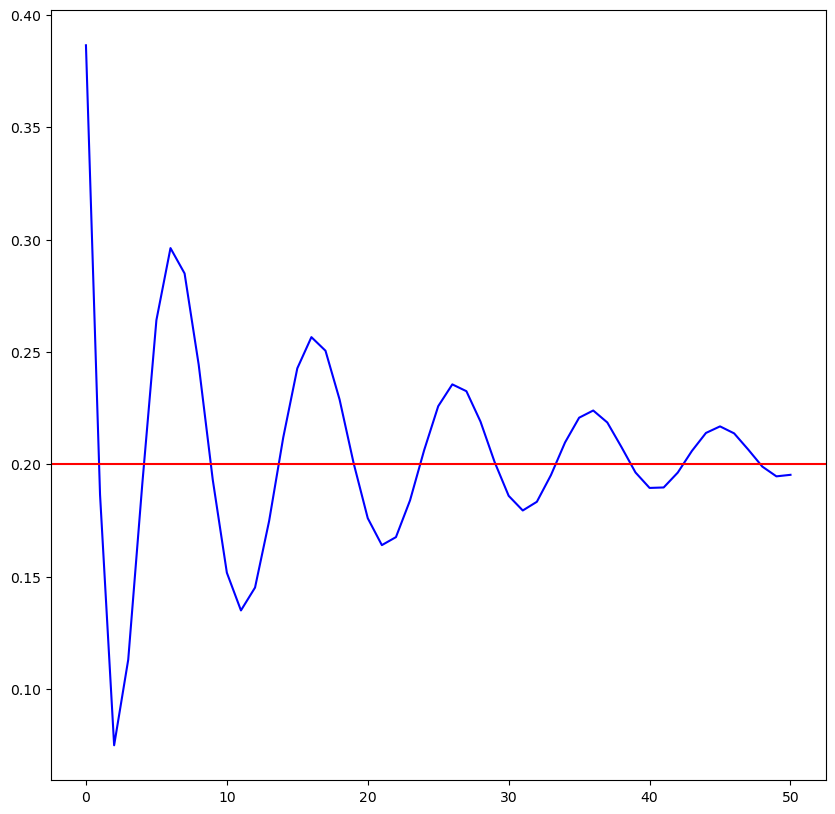

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ax.plot(np.array(param_list), color = "blue")
ax.axhline(y = beta.numpy(), color = "red")

We can even do multiple optimisation at th same time!

In [30]:
parallel_opti = 100

p_0_opti = tf.convert_to_tensor([[0.99, 0.01, 0.0]], dtype = tf.float32)*tf.ones((parallel_opti, 1))

gamma_opti = tf.convert_to_tensor(0.1, dtype = tf.float32)*tf.ones((parallel_opti))

q_opti = tf.convert_to_tensor([[0.0, 0.1, 0.0]], dtype = tf.float32)*tf.ones((parallel_opti, 1))

def loss_function(beta_to_optimise):

    _, LogLike_optim = compartmental_model_PAL(N, p_0_opti, beta_to_optimise, gamma_opti, q_opti, y_1t)

    return -tf.reduce_sum(LogLike_optim, axis = 0)

In [31]:
beta_to_optim = tf.convert_to_tensor(np.random.uniform(0.01, 0.99, parallel_opti), dtype = tf.float32)
while tf.reduce_any(loss_function(beta_to_optim)>1e10):

    beta_to_optim = tf.where(loss_function(beta_to_optim)>1e10, tf.convert_to_tensor(np.random.uniform(0.01, 0.99, parallel_opti), dtype = tf.float32), beta_to_optim)

beta_opti = tf.Variable(beta_to_optim)

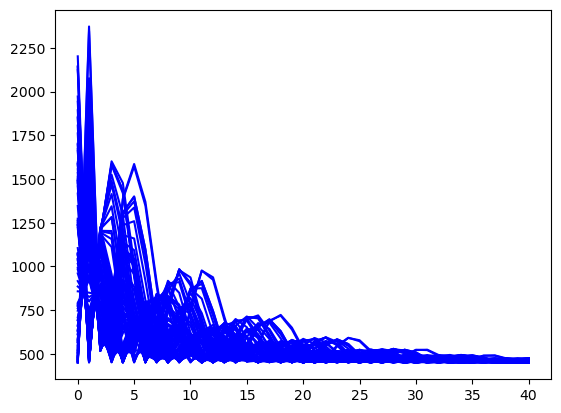

In [32]:
epochs = 50
loss_list = []
param_list = []
param_list.append(beta_opti.numpy())

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.2)

for i in range(epochs):


    with tf.GradientTape() as tape:
        # Call your likelihood function with the parameters_var and other necessary inputs
        loss = loss_function(beta_opti)

    # Use TensorFlow's automatic differentiation to compute gradients
    gradients = tape.gradient(loss, [beta_opti])
    optimizer.apply_gradients(zip(gradients, [beta_opti]))

    loss_list.append(loss.numpy())
    param_list.append(beta_opti.numpy())

    if i%10==0:
        clear_output(wait=True)

        for j in range(parallel_opti):
            plt.plot(np.stack(loss_list)[:,j], color = "blue")

        plt.show()


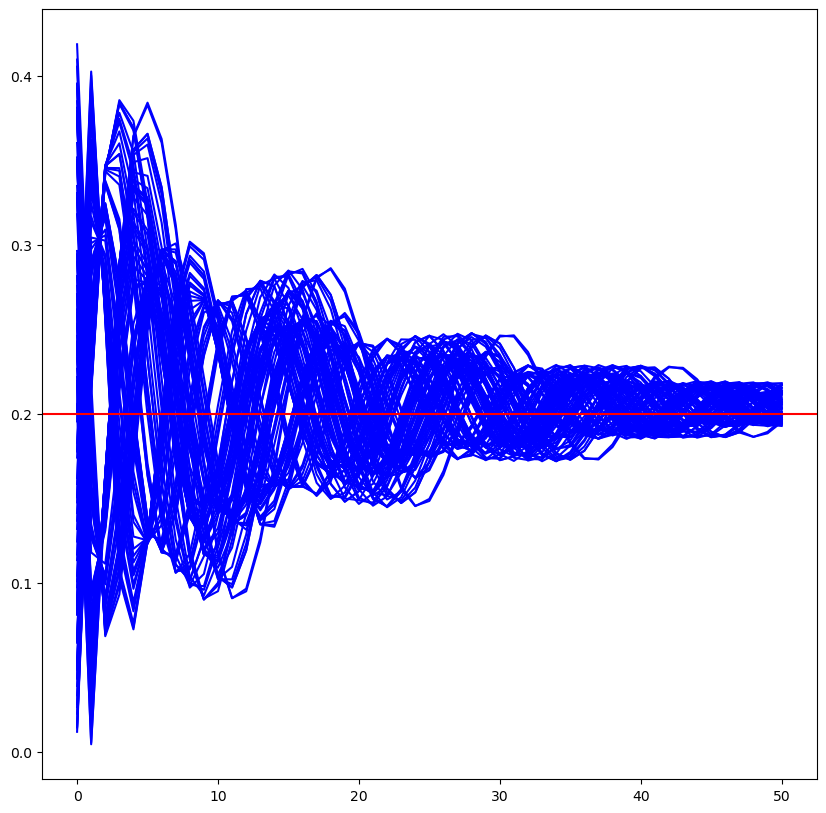

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

for j in range(parallel_opti):
    ax.plot(np.stack(param_list)[:,j], color = "blue")

ax.axhline(y = beta.numpy(), color = "red")